# Case study 2: Transient groundwater flow towards a spring

In this exercise we will apply the transient diffusion model that we have developed in exercise 3a to model a transient fluid flow system. We will look at groundwater discharge to a man-made spring (qanat) and how sensitive this spring is to changes in climate and recharge over time.

We will study the flow of groundwater to a so-called *qanat*, a man-made horizontal tunnel that taps the groundwater table and provides a year-round supply of groundwater. These qanats can be found in the Middle East, North Africa and Spain and predominantly date back to Roman times. We will study a qanat in northern Syria that has been restored in the early 2000s and provides a stable supply of groundwater to a small village called Shallalah Sagireh (little waterfall). The qanat dates back to at least the Byzantine age, since a byzantine artefact was found in the tunnel during restoration work. Currently the qanat provides approx. 0.4 L/s of water on average.

We will explore the question on how vulnerable qanats like these are to multi-year droughts. In practice we will use our 1D transient model of groundwater flow to simulate the steady-state initial flow to the qanat, and then model the change in flow after we have set the recharge to a value of 0.


## Workflow

1. Set up the model parameters and run the steady state model
2. Adjust K and S untill you get a reasonable water level (ie, make sure the qanat is not dry)
3. Fix the hydraulic head at the source of the qanat
4. Turn off recharge, run the transient model and quantify how long it takes before the qanat runs dry

### Set up model variables

Change the variables to model our qanat system. The model setup is shown schematically in Fig. 3

The system is 5.3 km long. Adjust the variable ``x`` in your script to make sure the model has the correct dimensions. 

The cross section starts at the central part of the valley at some distance from the qanat, where groundwater levels are relatively steady at 300 m above sea level. Use this as a value for h0.

The aquifer thickness is unknown, but is roughly estimated as 200 m. The transmissivity (=the product of hydraulic conductivity and aquifer tickness, K * b) of the aquifer has been estimated using an unpublished numerical model study for the larger surrounding area (Khanasser Valley) as 1.3 * 10^-5^ m^2^ s^-1^. This value is a first estimate, we will probably need to adjust this to get the watertable right.

Storarivity of the limestone rocks in which the formation was dug is probably relatively low. The formation is unconfined, so the storativity is dominated by the specific yield, which tends to be orders of magnitude higher than the elastic response of water and the rock matrix (=specific storage). We will use a first estimate of specific yield of 0.15.

The qanat is fed by recharge from the basalt plateau. Once upon a time I quantified recharge using the chloride mass balance (Luijendijk & Bruggeman 2008), ie. by looking at the difference in chloride concentration between groundwater and precipitation. The long-term average groundwater recharge was found to be 12 mm/yr, but with a large uncertainty range: 7 to 19 mm/yr. This is only a small fraction of the precipitation of approx. 300 mm/yr.

Both the chloride concentration of groundwater and the groundwater level contours suggest that recharge occurs only on the basalt plateau. In our model cross-section the basalt plateau runs from x=4100 m to x=5300 m. To accommodate lateral changes in recharge we should define recharge as an array instead of a single number. We can tell the script to vary recharge like this:

~~~~python
nx = len(x)
R = np.zeros(nx)
year = 365 * 24 * 60 * 60.0
R[41:] = 0.012 / year
~~~~

make sure then to recalculate the source term (W) as well.

### Adding the qanat

To add the qanat we will have to adjust the function that contains the iterative solver for steady-state flow (the function that starts with ``def run_model(...)``). Copy this function and give it a new name like ``run_model_qanat`` or something. We will use this function to calculate a steady-state waterlevel with an additional fixed head point located at the source of the qanat. 

The source of the qanat is located at 3800 m distance from the start of the cross-section, and the level of the bottom of the tunnel is 410 m.

Add two variables for the distance and the elevation of the qanat to the variable definition part of the code:

~~~~python
# specify water level and location of qanat tunnel
h_qanat = 410.0
x_qanat = 38
~~~~

Now we need to make sure these variables make it to your new steady-state flow function. Add ``x_qanat`` and ``h_qanat`` to the variable list. So for example instead of this:

~~~~python
def run_steady_state_model_with_qanat(x, dx, K, h0, W_rch):
~~~~

you would have the following function definition:

~~~~python
def run_steady_state_model_with_qanat(x, dx, K, h0, W_rch, x_qanat, h_qanat):
~~~~

(note the names of the variables may vary somewhat with your version of the script)

The final step to implementing the qanat is to tell the new iterative steady-state solver to fix the hydraulic head at the location of the qanat. We can do this by adding the next line inside the iterative solver loop in the new qanat function:

~~~~python
        # force fixed h at qanat
        h_new[x_qanat] = h_qanat
~~~~

make sure this line is located after the calculation of the other nodes (``h_new[1:-1] = ...``), otherwise this will get overwritten.

Now add lines to run the steady-state model twice, one time without and one time with the qanat:

~~~~python
# run steady-state model:
h_steady = run_steady_state_model(x, dx, K, h0, W_rch)

# calculate steady-state h with discharge to qanat:
h_steady_qanat = run_steady_state_model_with_qanat(x, dx, K, h0, W_rch, x_qanat, h_qanat)
~~~~

Now run the code and make sure it works well. Try to plot the modeled hdyraulic heads. The initial hydraulic head (h_steady) should be above the base of the qanat. 

### Modelling changes in flow over time:

Now lets modify the transient model runs to include the qanat as well. In addition we would like to record the flow towards the qanat to track any changes of this flow over time. 

First lets set up a variable to track the change in flow to the qanat over time. Add this somewhere before the start of your transient model code:

~~~~python
# make an array to store the flow into the qanat
q_qanat = np.zeros(n_timesteps)
~~~~

Secondly we have to add the fixed head to the transient code as well. However, we will make this conditional using an if statement, so that the fixed head is no longer maintained when h falls below the level of the qanat. Add 


~~~~python
    # check if the modeled waterlevel is still above the elevation of the qanat
    if h[j, x_qanat] > h_qanat:

        # if yes: force the specified waterlevel in the qanat
        h[j, x_qanat] = h_qanat
        
    else:
        # no flow in or out of the qanat anymore
	pass

~~~~

and finally we also want to know what the flow in and out of the qanat is. We can do this by simply using Darcy’s law to calculate the flux into and out of the node where the qanat is located:

~~~~python
    # check if the modeled waterlevel is still above the elevation of the qanat
    if h[j, x_qanat] > h_qanat:

        # if yes: force the specified waterlevel in the qanat
        h[j, x_qanat] = h_qanat
        
	# calculate q from an to the qanat
        q_in = K * b * (h[j, x_qanat+1] - h[j, x_qanat]) / dx
        q_out = K * b * (h[j, x_qanat] - h[j, x_qanat-1]) / dx
        q_qanat[j] = q_in - q_out

    else:
        # no flow in or out of the qanat anymore
        q_qanat[j] = 0

~~~~

Now we are all set to start modelling our very first qanat. Set recharge to 0 before the transient loop to model a multi-year drought.

## Assignments

Ok, we are all set now to start modelling flow to a qanat and how this responds to changes over time, explore some research questions, and submit a paper of our findings to Nature:

1. Adjust hydraulic conductivity (K) until the steady-state value of h (``h_steady``, the one without a qanat) is above the level of the qanat, but below the surface. In reality while digging the tunnel the diggers will probably have continued until they hit the groundwater table, and a little while further to capture as much water as possible. Make sure your simulated watertable is (somewhat) realistic, and report your best-estimate of the value of K, the hydraulic head at the source of the qanat and make a figure of the modeled watertable.
2. Simulate the transient change of flow to the qanat over time in case of a multi-year drought (ie. set the recharge to 0). Repeat using three different estimates of storativity. Look up typical variation of specific yield of consolidated carbonates online, in handbooks and/or your lecture notes. Report (inc. figures) how long it lasts until the qanat runs completely dry and at what stage the flow has reduced to 50% of the initial** value.
3. Change the value of recharge at the basalt plateau to its minimum and maximum estimate (7 mm/yr and 19 mm/yr). Readjust the initial steady-state value of hydraulic conductivity to maintain a realistic initial watertable and rerun the transient calculations. Again report how long it lasts until the qanat runs dry. What parameter is more important in determining the ‘resilience’ of the qanat, recharge, K or storativity?




# The actual model code:

## import python modules

In [155]:
import matplotlib

%matplotlib inline

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

## Function to calculate steady-state hydraulic head

In [156]:
def run_steady_state_model(x, dx, K, u0, W, n_iter=20000):
    
    C = (W * dx**2) / K

    u_new = np.ones_like(x) * u0
    u_old = np.ones_like(x) * u0

    # iterative solution steady-state h

    for t in range(n_iter):
    # make sure you indent anything below a for loop

        # set bnd conditions
        # left bnd:
        u_new[0] = u0
        # right bnd:
        u_new[-1] = 0.5 * (C[-1] + u_old[-1] + u_old[-2])

        # middle nodes:
        u_new[1:-1] = 0.5 * (C[1:-1] + u_old[2:] + u_old[:-2])

        u_old = u_new.copy()

    return u_new

## Model parameters

In [157]:
day = 24.0 * 60.0 * 60.0
year = 365 * 24 * 60 * 60.0

L = 5300.0
dx = 100.0

# thickness, use this for vertically integrated flow only, otherwise us b=1
b = 200.0

# hydraulic conductivity
K = 1.3e-5 / b

## Set up arrays

In [158]:

x = np.arange(0, L + dx, dx)

# source term
W = np.zeros_like(x)

# for qanat exercise: specify source term using a recharge of 12 mm/yr on the basalt plateau
# note, look up correct equation for the source term in handouts exercise 1
x_basalt = 20000
#W[x > x_basalt] = 0.012 / year

## Parameters for transient model runs

In [159]:
# specify storage coefficient
# for unconfined groundwater flow this is the specific yield
# for confined this is the specific storage
porosity = 0.1
density = 1000.0
g = 9.81
S = 1e-4

# timestep size
dt = 1.0 * day

#total duration
duration = 2.0 * year

# calculate total number of timesteps
n_timesteps = int(duration / dt)

# left-hand boudnary condition
h_bnd = 300.0
h0 = np.ones((n_timesteps)) * h_bnd

## run steady-state model

We will first run the steady state model. The steady state value of h will be used as an initial value for the transient model runs

In [160]:
h_steady = run_steady_state_model(x, dx, K, h_bnd, W)

## Set up parameters for the transient model

In [161]:
# set up array that records timesteps:
time = np.arange(n_timesteps) * dt

# define array to store flux and the variable over time:
n_nodes = len(x)
h = np.zeros((n_timesteps, n_nodes))

# set the steady-state value of u as value for first timestep
h[0] = h_steady

## run the transient model:

In [162]:
for j in range(1, n_timesteps):
    
    # calculate the flux between nodes
    q = -K * b * (h[j-1, 1:] - h[j-1, :-1]) / dx

    # set specified variable value at the left-hand node:
    h[j, 0] = h0[j]

    # implement no-flow boundary condition at right-hand side:
    q_right = 0.0
    h[j, -1] = h[j-1, -1] + (dt/S) * (-(q_right - q[-1])/dx) + (dt / S) * W[-1] * b

    # update nodes in the middle:
    h[j, 1:-1] = h[j-1, 1:-1] + (dt/S)*(-(q[1:] - q[:-1])/dx) + (dt/S) * W[1:-1] * b

    # print results to screen each 100 timesteps
    if int(j / 365) == float(j / 365):
        print('time = ', ((j * dt) / year), ', min, max value of h = ', h[j].min(), h[j].max())

## Normalize qanat discharge

In [1]:
#q_qanat = q_qanat / q_qanat.max()

NameError: name 'q_qanat' is not defined

## Load elevation vs distance data

In [163]:
csv_file = pd.read_csv('cross_section_qanat.csv')

## Create a figure:

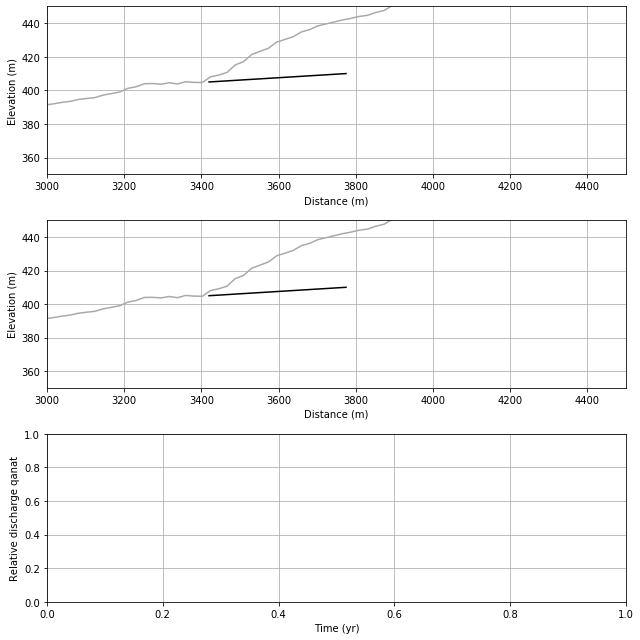

In [164]:
nt = n_timesteps

# create a new figure with 3 panels
fig, panels = pl.subplots(3, 1, figsize=(9, 9))

# first panel: show steady-state h
panels[0].plot(x, h_steady, color='blue', ls='--', label='steady-state')
#panels[0].plot(x, h[-1], color='darkblue', ls='-', label='transient')

# second panel, show change in hydraulic head over time
output_timesteps = np.linspace(0, nt, 5)
for j in output_timesteps:
    panels[1].plot(x, h[j])

# first 2 panels: draw a line to show where the qanat is
panels[0].plot([3775.0, 3420.0], [410.0, 405.0], color='black')
panels[1].plot([3775.0, 3420.0], [410.0, 405.0], color='black')

# and show the surface elevation
panels[0].plot(csv_file['distance'], csv_file['elevation'], color='darkgray')
panels[1].plot(csv_file['distance'], csv_file['elevation'], color='darkgray')

# last panel: show flow over time
year = 365 * 24 * 60.0 * 60.0
timesteps = np.arange(nt) * dt / year
#panels[2].plot(timesteps, q_qanat)

panels[0].set_xlabel('Distance (m)')
panels[1].set_xlabel('Distance (m)')
panels[2].set_xlabel('Time (yr)')

panels[0].set_ylabel('Elevation (m)')
panels[1].set_ylabel('Elevation (m)')
panels[2].set_ylabel('Relative discharge qanat')

panels[0].set_xlim(3000, 4500)
panels[1].set_xlim(3000, 4500)
panels[0].set_ylim(350, 450)
panels[1].set_ylim(350, 450)

for panel in panels:
    panel.grid()

fig.tight_layout()

fig.savefig('simulated_h_qanat_transient.pdf')

### A figure of h over time for a specific depth

# References

Luijendijk, Elco, and Adriana Bruggeman. 2008. “Groundwater Resources in the Jabal Al Hass Region, Northwest Syria: An Assessment of Past Use and Future Potential.” Hydrogeology Journal 16 (3): 511–30.


Note, you can find these publications using google scholar: https://scholar.google.com

![cross-section of the qanat. Note that the elevation data are not correct (constructed pre GPS age), the outlet is location at 405 m above sea level](figs/qanat_xsection_small.png)
*Cross-section of the qanat. Note that the elevation data are not correct (this cross-section was made pre GPS age), the outlet is located at 405 m above sea level*

![Map of the elevation, geology and location of the qanat and the 1D cross-section](figs/qanat_map.png)
*Map of the elevation, geology and location of the qanat and the 1D cross-section*

![Overview of the model setup along the 1D cross-section. The valley bottom is located at the left, basalt plateau at the right. Surface elevation in gray, qanat tunnel in black and modeled waterlevel in blue. Note that the waterlevel exceeds the surface at the left hand side of the model domain, which is probably not realistic, but does not affect our model results. Hydraulic conductivity is probably higher than average in the valley (quaternary sediments).](figs/model_overview.png)
*Overview of the model setup along the 1D cross-section. The valley bottom is located at the left, basalt plateau at the right. Surface elevation in gray, qanat tunnel in black and modeled waterlevel in blue. Note that the waterlevel exceeds the surface at the left hand side of the model domain, which is probably not realistic, but does not affect our model results. Hydraulic conductivity is probably higher than average in the valley (Quaternary sediments).*